# Использование бустинга в DMF. Оптимальная степень полинома

In [1]:
import numpy as np
from copy import copy
import pandas as pd
from tqdm.auto import tqdm

from scipy.integrate import quad
from scipy.stats import genextreme

from statsmodels.discrete.discrete_model import MNLogit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from statsmodels.regression.linear_model import OLS
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate, LeaveOneOut, KFold
from sklearn.metrics import roc_auc_score, accuracy_score

from IPython.display import clear_output
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
beta_spend = np.array([1, 0.1, 0.0001, 1])
betas = np.array([[0.1, 0.000025, 0.3, 0.01],
                  [0.2, 0.000015, 0.2, 0.015],
                  [3, -0.00002, 0.5, -0.02]])

In [3]:
def generate_sample(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    eps = genextreme.rvs(c=0, size=(n, 3))
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    rho = np.array([0.64, -0.25, 0.14])
    mevd, __ = quad(lambda x: genextreme.pdf(x, c=0) * x, -100, 100)
    m2evd, __ = quad(lambda x: genextreme.pdf(x, c=0) * x ** 2, -100, 100)
    vevd = m2evd - mevd ** 2
    vevd_rho = np.sum(vevd * rho ** 2)
    adj = np.sqrt(6) / np.pi
    sigma = 4
    
    eps_spend = sigma * adj * (eps - mevd) @ rho + \
                np.random.normal(size=n, loc=0, scale=np.sqrt(sigma ** 2 - (sigma * adj * np.sqrt(vevd_rho) ** 2)))

    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

In [4]:
np.random.seed(4)

df = generate_sample(1000, verbose=True)
df.head()

2    481
0    289
1    230
Name: transport, dtype: int64


,const,income,health,age,drive,y_star_Car,y_star_Taxi,y_star_Public,transport,spend
0,1.0,22820.013044,3,32.0,4,4.662237,2.942691,6.678108,2,NaN
1,1.0,31255.978012,3,45.0,0,2.116802,5.361839,2.351739,1,NaN
2,1.0,10969.387836,5,68.0,3,2.718885,2.887521,3.999501,2,NaN
3,1.0,35793.405654,2,21.0,5,2.158243,2.879407,4.122440,2,NaN
4,1.0,16435.336097,3,51.0,3,2.464228,1.464279,3.759046,2,NaN


In [5]:
X, y = df[['const', 'income', 'health', 'age']], df['transport']
all_coefs = []
        
## Обычная линейная регрессия
df_no_nans = df.dropna()
X_spend = df_no_nans[['age', 'income', 'drive']]
y_spend = df_no_nans['spend']
lm = LinearRegression().fit(X_spend, y_spend)
all_coefs.append(['МНК', lm.intercept_] + list(lm.coef_))

In [6]:
# # LogReg sklearn
# lr = LogisticRegression(penalty='none', fit_intercept=False, multi_class='multinomial').fit(X, y)
# prob = lr.predict_proba(X)

# MNLogit statsmodels
lr = MNLogit(y, X).fit(method='newton', maxiter=10000)
prob = lr.predict()

## Лямбды
df['lambda1'] = -np.log(prob[:, 0])
df['lambda2'] = prob[:, 1] * np.log(prob[:, 1]) / (1 - prob[:, 1])
df['lambda3'] = prob[:, 2] * np.log(prob[:, 2]) / (1 - prob[:, 2])

df_no_nans = df.dropna()
X_spend = df_no_nans[['age', 'income', 'drive']]
y_spend = df_no_nans['spend']

## Линейная модель
dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                         'lambda1', 'lambda2', 'lambda3']], y_spend)
all_coefs.append(['Дурбин-МакФадден', dmf.intercept_] + list(dmf.coef_[:3]))

Optimization terminated successfully.
         Current function value: 0.935559
         Iterations 6


In [7]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              transport   No. Observations:                 1000
Model:                        MNLogit   Df Residuals:                      992
Method:                           MLE   Df Model:                            6
Date:                Sun, 05 Feb 2023   Pseudo R-squ.:                  0.1080
Time:                        13:41:08   Log-Likelihood:                -935.56
converged:                       True   LL-Null:                       -1048.8
Covariance Type:            nonrobust   LLR p-value:                 4.280e-46
===============================================================================
transport=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1151      0.343     -0.336      0.737      -0.786       0.556
income       -5.01e-06   3.68e-06     -1.361      0.173   -1.22e-05     2.2e-06
health         -0.1007      0.062     -1.629      0.103      -0.222       0.020
age             0.0049      0.004      1.244      0.214      -0.003       0.013
-------------------------------------------------------------------------------
transport=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.5704      0.306      8.402      0.000       1.971       3.170
income      -4.657e-05   5.05e-06     -9.224      0.000   -5.65e-05   -3.67e-05
health          0.2171      0.056      3.843      0.000       0.106       0.328
age            -0.0240      0.004     -6.734      0.000      -0.031      -0.017
===============================================================================
"""

In [8]:
OLS(y_spend, df_no_nans[['age', 'income', 'drive', 
                         'lambda1', 'lambda2', 'lambda3']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  spend   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              581.0
Date:                Sun, 05 Feb 2023   Prob (F-statistic):                   6.78e-156
Time:                        13:41:09   Log-Likelihood:                         -849.87
No. Observations:                 289   AIC:                                      1712.
Df Residuals:                     283   BIC:                                      1734.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0888      0.018      4.852      0.000       0.053       0.125
income         0.0001   1.43e-05      7.664      0.000    8.13e-05       0.000
drive          0.6963      0.186      3.747      0.000       0.330       1.062
lambda1        1.9490      1.709      1.140      0.255      -1.415       5.313
lambda2       -2.5573      3.417     -0.748      0.455      -9.284       4.169
lambda3       -1.2380      3.266     -0.379      0.705      -7.666       5.190
==============================================================================
Omnibus:                        4.023   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                4.917
Skew:                          -0.056   Prob(JB):                       0.0856
Kurtosis:                       3.629   Cond. No.                     6.02e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
all_coefs = []
all_coefs.append(['Истина', 1, 0.1, 0.0001, 1])
all_coefs.append(['МНК', lm.intercept_] + list(lm.coef_))
all_coefs.append(['Дурбин-МакФадден', dmf.intercept_] + list(dmf.coef_[:3]))

pd.DataFrame(all_coefs, columns=['method', 'const', 'b1', 'b2', 'b3'])

,method,const,b1,b2,b3
0,Истина,1.000000,0.100000,0.000100,1.000000
1,МНК,5.954993,0.076271,0.000080,0.705369
2,Дурбин-МакФадден,15.397569,0.077156,0.000051,0.692962


## Ошибки не по Гумбелю
### а) Многомерное нормальное

In [17]:
mu = np.array([0, 0, 0, 0])

cov = np.array([[1   , 0.5 , -0.2, 0.1 ],
                [0.5 , 1   , 0.25, -0.1],
                [-0.2, 0.25, 1   , 0.7 ],
                [0.1 , -0.1, 0.7 , 1   ]])

np.random.multivariate_normal(mean=mu, cov=cov, size=1000)

array([[-1.45206952, -0.93120404,  0.21226216,  0.25273917],
       [-0.41051015,  1.4475736 , -0.13113773, -0.7118186 ],
       [-0.58139681, -0.72107776,  1.37309482,  1.53563704],
       ...,
       [ 0.66493743,  0.06074358, -0.71245419, -0.55017408],
       [ 0.60505047,  0.721411  , -0.88653091, -1.03199916],
       [-1.79462533, -0.97659186,  0.71112438,  1.60613677]])

In [18]:
def generate_sample2(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    all_eps = np.random.multivariate_normal(mean=mu, cov=cov, size=n)
    eps = all_eps[:, :3]
    eps_spend = all_eps[:, 3]
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

### б) Экспоненциальное распределение ошибок

In [20]:
def generate_sample3(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    all_eps = np.random.exponential(1, size=(n, 4)) - 1
    eps = all_eps[:, :3]
    eps_spend = all_eps[:, 3]
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

### Полиномы (подобранные на кросс-валидации по 10 фолдам)

### Экспоненциальное распределение

In [21]:
def simulate7(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample3(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=10)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

In [22]:
np.random.seed(999)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
best_ks_low = []
best_ks_up = []
best_ks_mid = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate7(n_simulations, n_size)

    best_ks_low.append(np.quantile(best_ks, 0.05))
    best_ks_up.append(np.quantile(best_ks, 0.95))
    best_ks_mid.append(np.quantile(best_ks, 0.5))
    
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


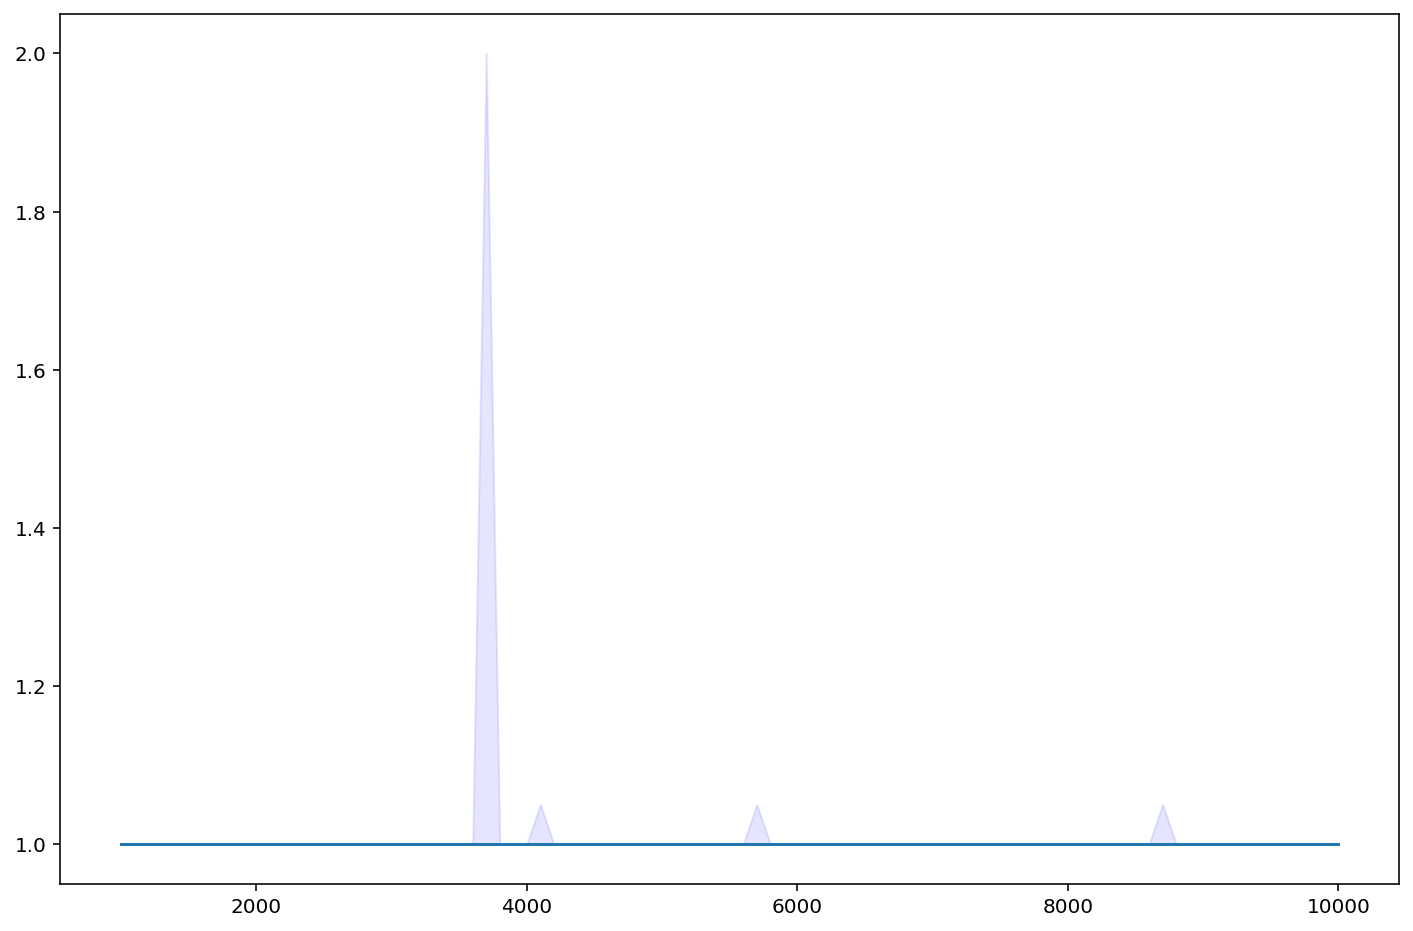

In [23]:
plt.plot(n_sizes, best_ks_mid)
plt.fill_between(n_sizes, best_ks_low, best_ks_up, color='b', alpha=.1);

### Ошибки из многомерного нормального

In [28]:
def simulate8(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample2(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=10)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

In [29]:
np.random.seed(999)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
best_ks_low = []
best_ks_up = []
best_ks_mid = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate8(n_simulations, n_size)

    best_ks_low.append(np.quantile(best_ks, 0.05))
    best_ks_up.append(np.quantile(best_ks, 0.95))
    best_ks_mid.append(np.quantile(best_ks, 0.5))
    
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


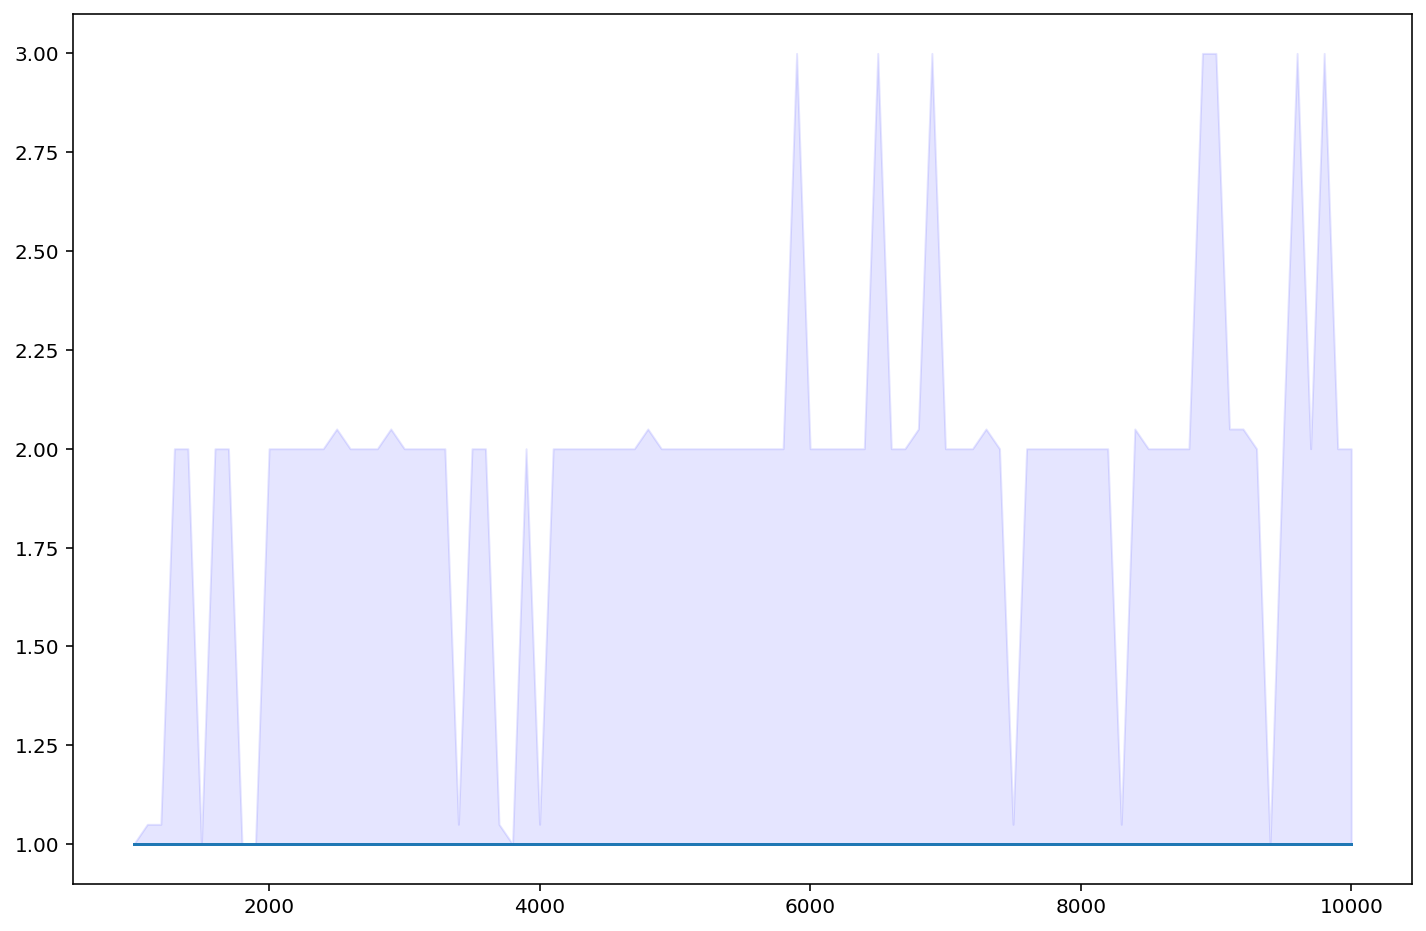

In [30]:
plt.plot(n_sizes, best_ks_mid)
plt.fill_between(n_sizes, best_ks_low, best_ks_up, color='b', alpha=.1);

### Ошибки из Гумбеля

In [31]:
def simulate9(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    best_ks = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=10)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        best_ks.append(best_k)
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, best_ks
        

In [32]:
np.random.seed(999)

n_sizes = np.arange(1000, 10100, 100)
n_simulations = 100
best_ks_low = []
best_ks_up = []
best_ks_mid = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, best_ks = simulate9(n_simulations, n_size)

    best_ks_low.append(np.quantile(best_ks, 0.05))
    best_ks_up.append(np.quantile(best_ks, 0.95))
    best_ks_mid.append(np.quantile(best_ks, 0.5))
    
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


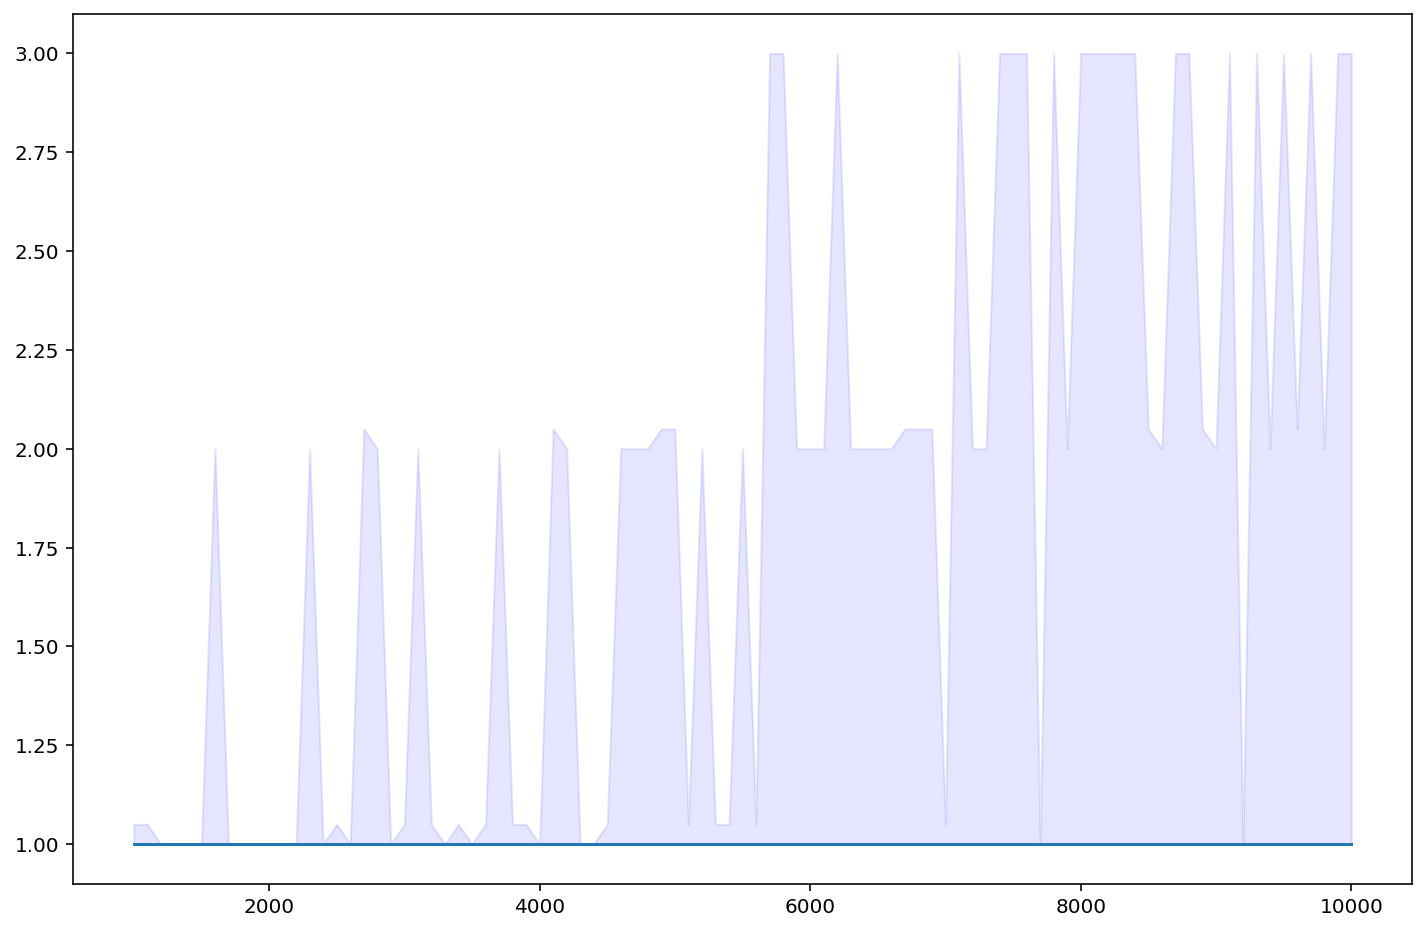

In [33]:
plt.plot(n_sizes, best_ks_mid)
plt.fill_between(n_sizes, best_ks_low, best_ks_up, color='b', alpha=.1);

In [37]:
generate_sample3(n=10000, verbose=True)[['y_star_Car', 'y_star_Taxi', 'y_star_Public']].var()

2    5202
0    2688
1    2110
Name: transport, dtype: int64


y_star_Car       1.507273
y_star_Taxi      1.266425
y_star_Public    1.988271
dtype: float64

In [38]:
generate_sample(n=10000, verbose=True)[['y_star_Car', 'y_star_Taxi', 'y_star_Public']].var()

2    4754
0    2823
1    2423
Name: transport, dtype: int64


y_star_Car       2.187364
y_star_Taxi      1.964504
y_star_Public    2.538554
dtype: float64